In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils, Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
import keras

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing

In [3]:
# image specification
img_cols,img_rows=100,176
nb_frames = 64    # img_depth or number of frames used for each video
# CNN Training parameters
nb_classes = 27
channels = 2

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# integer encode
labels = pd.read_csv('E:\Jupyter\Project\jester-v1-labels.csv',sep=';',header=None,names=['Class'])     # reading the csv file
label_encoder = LabelEncoder()
labels['Label'] = label_encoder.fit_transform(labels['Class'])

#train
train = pd.read_csv('E:\Jupyter\Project\jester-v1-train.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = pd.read_csv('E:\Jupyter\Project\jester-v1-validation.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = temp["Label"].to_dict()
len(train)

118562

In [5]:
#train
train = train[train["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])]
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = validation[validation["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])]
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = {}
labels_dict = temp["Label"].to_dict()
len(train)

25025

In [5]:
import random
def data_gen(train_list, batch_size=64):
    while True:
        X_tr=[]
        label=[]
        for vid_ID in random.sample(train_list,batch_size):
            frames = []
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                if frame_count < nb_frames:
                    pos = os.path.join(pos_dir,img_ID)
                    neg = os.path.join(neg_dir,img_ID)
                    p_img = cv2.imread(pos,0)
                    p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    n_img = cv2.imread(neg,0)
                    n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    frame = cv2.merge((p_img,n_img))
                    frames.append(frame)
                    frame_count+=1
                else:
                    break
            while frame_count < nb_frames:
                frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
                frame_count+=1
            input_img = np.array(frames)
            ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
            ipt=np.rollaxis(ipt,2,0)
            X_tr.append(ipt)
            label.append(labels_dict[vid_ID])

        X_tr_array = np.array(X_tr)   # convert the frames read into array

        Y_train = np_utils.to_categorical(label, nb_classes)

        yield X_tr_array,Y_train

In [6]:
print(next(data_gen(train["Video"].tolist()))[0].shape)

(64, 64, 100, 176, 2)


In [7]:
# Define model
import tensorflow as tf
keras=tf.contrib.keras
l2=keras.regularizers.l2
weight_decay = 0.00005
from keras import regularizers

model = Sequential()
model.add(MaxPooling3D(pool_size=(1, 2, 2),input_shape=(nb_frames,  img_cols, img_rows, channels)))

model.add(Conv3D(8,(1,5,5),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(8,(5,1,1),activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(32,(1,5,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(32,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64,(1,3,5), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv3D(64,(3,1,1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 1, 4 )))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm1'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm2'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm3'))


model.add(Flatten())
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(nb_classes,kernel_initializer='normal',kernel_regularizer=regularizers.l2(weight_decay)))

model.add(Activation('softmax'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_1 (MaxPooling3 (None, 64, 50, 88, 2)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 46, 84, 8)     408       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 46, 84, 8)     328       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 60, 23, 42, 8)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 60, 19, 38, 32)    6432      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 58, 19, 38, 32)    3104      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 29, 9, 19, 32)     0         
__________

In [9]:
import os
save_dir = os.path.join(os.getcwd(),'save_model')
print(os.getcwd())
model_name = "deep"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

E:\Jupyter\Project


In [10]:
sgd = SGD(lr=0.002,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])

In [11]:
nb_epoch = 150
batch_size = 32
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit_generator(data_gen(train["Video"].tolist()[0:],batch_size),
                           validation_data=data_gen(validation["Video"].tolist()[0:],batch_size),
                           steps_per_epoch=len(train["Video"].tolist()[0:])//(16*batch_size),
                           validation_steps=len(validation["Video"].tolist()[0:])//(16*batch_size),
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/150
48/48 [==============================] - 138s 3s/step - loss: 2.4197 - acc: 0.2604 - val_loss: 1.6963 - val_acc: 0.3937

Epoch 00001: val_acc improved from -inf to 0.39375, saving model to E:\Jupyter\Project\save_model\deep
Epoch 2/150
48/48 [==============================] - 129s 3s/step - loss: 1.8189 - acc: 0.3750 - val_loss: 1.5870 - val_acc: 0.4688

Epoch 00002: val_acc improved from 0.39375 to 0.46875, saving model to E:\Jupyter\Project\save_model\deep
Epoch 3/150
48/48 [==============================] - 129s 3s/step - loss: 1.6361 - acc: 0.4388 - val_loss: 1.4875 - val_acc: 0.5188

Epoch 00003: val_acc improved from 0.46875 to 0.51875, saving model to E:\Jupyter\Project\save_model\deep
Epoch 4/150
48/48 [==============================] - 128s 3s/step - loss: 1.5035 - acc: 0.5254 - val_loss: 1.3920 - val_acc: 0.5563

Epoch 00004: val_acc improved from 0.51875 to 0.55625, saving model to E:\Jupyter\Project\save_model\deep
Epoch 5/150
48/48 [============================

48/48 [==============================] - 121s 3s/step - loss: 0.6867 - acc: 0.8372 - val_loss: 0.7572 - val_acc: 0.8187

Epoch 00041: val_acc did not improve from 0.86875
Epoch 42/150
48/48 [==============================] - 119s 2s/step - loss: 0.7298 - acc: 0.8112 - val_loss: 0.7668 - val_acc: 0.8063

Epoch 00042: val_acc did not improve from 0.86875
Epoch 43/150
48/48 [==============================] - 118s 2s/step - loss: 0.7011 - acc: 0.8164 - val_loss: 0.7144 - val_acc: 0.8250

Epoch 00043: val_acc did not improve from 0.86875

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 44/150
48/48 [==============================] - 120s 3s/step - loss: 0.6449 - acc: 0.8457 - val_loss: 0.6444 - val_acc: 0.8438

Epoch 00044: val_acc did not improve from 0.86875
Epoch 45/150
48/48 [==============================] - 126s 3s/step - loss: 0.6579 - acc: 0.8431 - val_loss: 0.7162 - val_acc: 0.8125

Epoch 00045: val_acc did not improve from 0.86875
Epoch 46/150

48/48 [==============================] - 121s 3s/step - loss: 0.5230 - acc: 0.8978 - val_loss: 0.5140 - val_acc: 0.8875

Epoch 00084: val_acc did not improve from 0.93125
Epoch 85/150
48/48 [==============================] - 120s 2s/step - loss: 0.5453 - acc: 0.8861 - val_loss: 0.5904 - val_acc: 0.8812

Epoch 00085: val_acc did not improve from 0.93125
Epoch 86/150
48/48 [==============================] - 121s 3s/step - loss: 0.5733 - acc: 0.8841 - val_loss: 0.7529 - val_acc: 0.8500

Epoch 00086: val_acc did not improve from 0.93125

Epoch 00086: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 87/150
48/48 [==============================] - 121s 3s/step - loss: 0.5591 - acc: 0.8893 - val_loss: 0.6833 - val_acc: 0.8313

Epoch 00087: val_acc did not improve from 0.93125
Epoch 88/150
48/48 [==============================] - 119s 2s/step - loss: 0.5470 - acc: 0.8893 - val_loss: 0.6400 - val_acc: 0.8625

Epoch 00088: val_acc did not improve from 0.93125
Epoch 89/150


Epoch 00126: val_acc did not improve from 0.93125
Epoch 127/150
48/48 [==============================] - 121s 3s/step - loss: 0.4757 - acc: 0.9134 - val_loss: 0.5646 - val_acc: 0.9000

Epoch 00127: val_acc did not improve from 0.93125

Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 128/150
48/48 [==============================] - 121s 3s/step - loss: 0.5084 - acc: 0.9043 - val_loss: 0.5869 - val_acc: 0.9062

Epoch 00128: val_acc did not improve from 0.93125
Epoch 129/150
48/48 [==============================] - 124s 3s/step - loss: 0.4776 - acc: 0.9219 - val_loss: 0.5458 - val_acc: 0.8938

Epoch 00129: val_acc did not improve from 0.93125
Epoch 130/150
48/48 [==============================] - 123s 3s/step - loss: 0.5029 - acc: 0.9141 - val_loss: 0.4113 - val_acc: 0.9563

Epoch 00130: val_acc improved from 0.93125 to 0.95625, saving model to E:\Jupyter\Project\save_model\deep
Epoch 131/150
48/48 [==============================] - 119s 2s/step - lo

In [31]:
model.evaluate_generator(data_gen(validation["Video"].tolist()[0:],batch_size),
                         len(validation["Video"].tolist()[0:])//(batch_size))

[0.5514316449039861, 0.9]

In [14]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

In [15]:
"""for entry in hist1.history['loss']:
    training_loss.append(entry)
for entry in hist1.history['val_loss']:
    val_loss.append(entry)
for entry in hist1.history['acc']:
    training_acc.append(entry)
for entry in hist1.history['val_acc']:
    val_acc.append(entry)"""

"for entry in hist1.history['loss']:\n    training_loss.append(entry)\nfor entry in hist1.history['val_loss']:\n    val_loss.append(entry)\nfor entry in hist1.history['acc']:\n    training_acc.append(entry)\nfor entry in hist1.history['val_acc']:\n    val_acc.append(entry)"

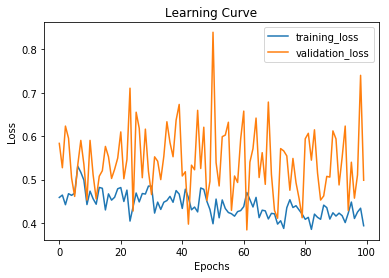

"with open('deeploss_tr.pkl','rb') as fid:\n    training_loss = pickle.load(fid)"

In [16]:
import pickle
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

with open('E:/Jupyter/Project/save_model/deeploss_tr.pkl','wb') as fid:
    pickle.dump(training_loss, fid)
with open('E:/Jupyter/Project/save_model/deeploss_val.pkl','wb') as fid:
    pickle.dump(val_loss, fid)
"""with open('deeploss_tr.pkl','rb') as fid:
    training_loss = pickle.load(fid)"""

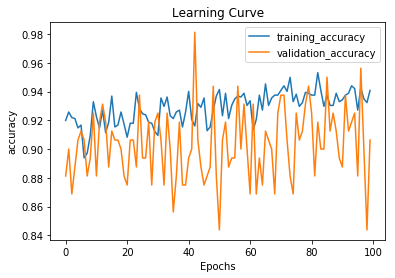

In [17]:

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

with open('E:/Jupyter/Project/save_model/deepacc_tr.pkl','wb') as fid:
    pickle.dump(training_acc, fid)
with open('E:/Jupyter/Project/save_model/deepacc_val.pkl','wb') as fid:
    pickle.dump(val_acc, fid)

In [6]:
from keras.models import Model, load_model
model1_name = "deep"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)

NameError: name 'save_dir' is not defined

In [20]:
test_pred =model1.predict(train_set[50:70])
result = np.argmax(test_pred, axis =1)
print(result)

[0 0 0 0 0 0 0 0 3 0 0 0 4 3 0 0 0 0 0 3]


In [21]:
img_array = train_set[50]
from sklearn.metrics import confusion_matrix
met = confusion_matrix(np.argmax(Y_train,axis =1), np.argmax(model1.predict(train_set),axis =1))
print(met)
met = [[]]

[[267   0   0   1   0   0]
 [141   6   6  71   3   5]
 [145   2  23  88   2   1]
 [215   0   0  40   1   0]
 [150   0   0  53  41   1]
 [135   0   0  48   4  51]]


In [22]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

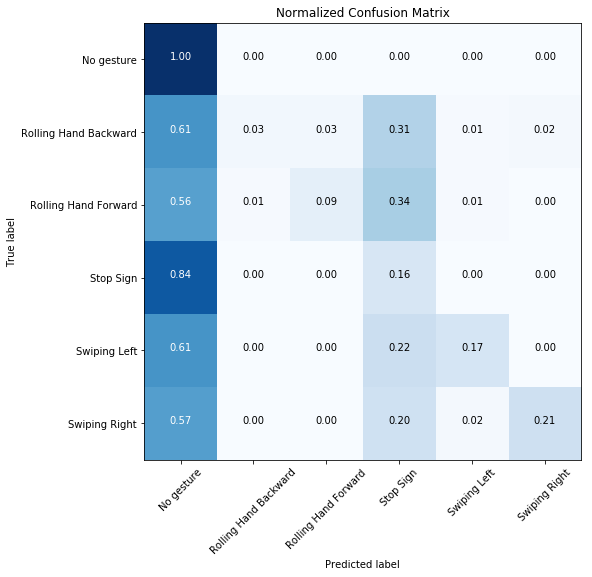

In [23]:
confusion_matrix_plot(met, classes=labels[labels["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])].sort_values(by=['Label'])['Class'].tolist())

In [24]:
model1.evaluate(train_set,Y_train)

1500/1500 [==============================] - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 57 - ETA: 56 - ETA: 53 - ETA: 51 - ETA: 49 - ETA: 47 - ETA: 44 - ETA: 42 - ETA: 40 - ETA: 38 - ETA: 36 - ETA: 34 - ETA: 32 - ETA: 30 - ETA: 28 - ETA: 26 - ETA: 24 - ETA: 22 - ETA: 20 - ETA: 18 - ETA: 16 - ETA: 14 - ETA: 13 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - 89s 59ms/step


[4.131080926259359, 0.28533333317438764]

In [25]:
model.evaluate(train_set,Y_train)

1500/1500 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 57s - ETA: 55 - ETA: 53 - ETA: 52 - ETA: 50 - ETA: 48 - ETA: 46 - ETA: 44 - ETA: 41 - ETA: 39 - ETA: 37 - ETA: 36 - ETA: 34 - ETA: 32 - ETA: 30 - ETA: 28 - ETA: 26 - ETA: 24 - ETA: 22 - ETA: 21 - ETA: 19 - ETA: 17 - ETA: 15 - ETA: 13 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - 90s 60ms/step


[3.1296281255086265, 0.4259999997615814]

(1, 64, 100, 176, 2)
(1, 64, 50, 88, 2) max_pooling3d_1
(1, 64, 46, 84, 8) conv3d_1
(1, 60, 46, 84, 8) conv3d_2
(1, 60, 23, 42, 8) max_pooling3d_2
(1, 60, 19, 38, 32) conv3d_3
(1, 58, 19, 38, 32) conv3d_4
(1, 29, 9, 19, 32) max_pooling3d_3
(1, 29, 7, 15, 64) conv3d_5
(1, 27, 7, 15, 64) conv3d_6
(1, 27, 7, 3, 64) max_pooling3d_4
(1, 27, 7, 3, 64) gatedclstm1
(1, 27, 7, 3, 64) gatedclstm2


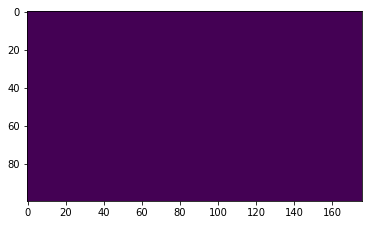

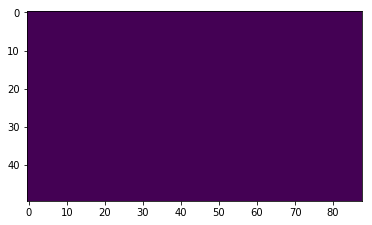

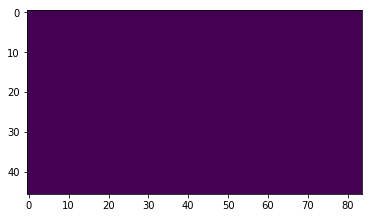

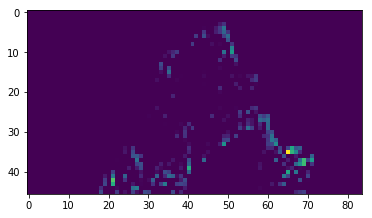

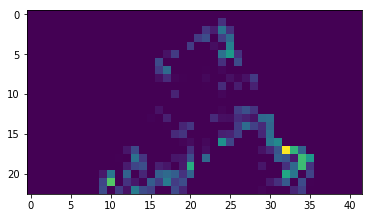

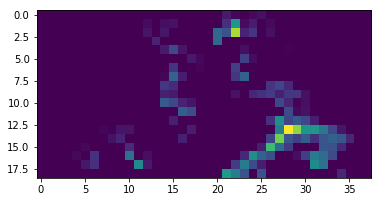

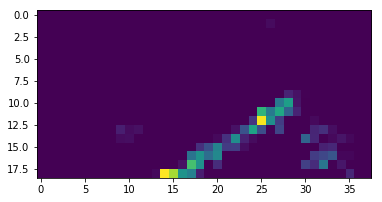

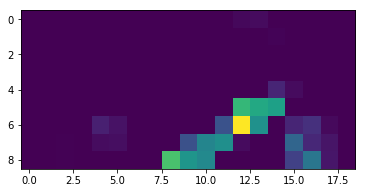

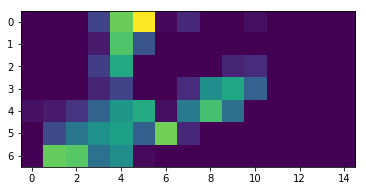

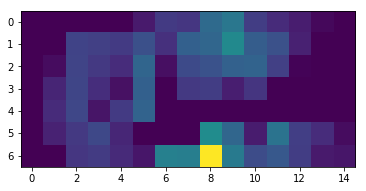

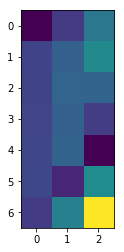

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

layer_outputs = [layer.output for layer in model1.layers[:12]]
activation_model = Model(inputs=model1.input, outputs=layer_outputs)
activations=activation_model.predict(train_set[50:51])
print(train_set[50:51].shape)
fig = plt.figure()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(train_set[50:51].shape[1]):
    im = plt.imshow(train_set[50:51][0, i, :,:, 0], cmap='viridis')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ani.save('input' + '.mp4')

layer_num = 0
layer_names=[]
for layer in model1.layers[:15]:
    layer_names.append(layer.name)
for layer_name, layer_activation in zip(layer_names, activations):

    fig = plt.figure()

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    print(layer_activation.shape,layer_name)
    if layer_num<10:
        for i in range(layer_activation.shape[1]):
            im = plt.imshow(layer_activation[0, i, :,:, 0], cmap='viridis')
            ims.append([im])
     
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save('activation' + str(layer_num) + layer_name + '.mp4')
        layer_num +=1

(1, 64, 50, 88, 2)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:865: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


ValueError: could not broadcast input array from shape (60,19,32) into shape (60,60)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


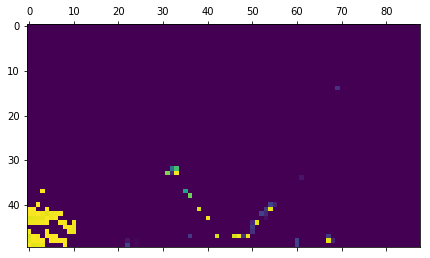

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

In [27]:
layer_outputs = [layer.output for layer in model1.layers[:12]]
activation_model = Model(inputs=model1.input, outputs=layer_outputs)
activations=activation_model.predict(train_set[0:1])

first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, 0, :,:, 0], cmap='viridis')

layer_names = []
for layer in model1.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')